# Dataset Question Inspector

Use this notebook to review questions in the dataset.

**How to use**
1. Set `dataset_path`, plus either `row_indices` (0-based) or `row_ids` (values from the `id` column).
2. Run the helper cells to load the dataset and render the selected questions.

In [1]:
# --- Configuration ---
# Set this to the parquet file you want to inspect.
dataset_path = "datasets/dataset_full.edited.corrected.parquet"

# Provide 0-based row indices to inspect (e.g., from check_dataset errors).
row_indices = []  # example: [5, 9, 27]

# Optionally provide row ids (exact match on the `id` column).
row_ids = ["01_34_p1_efb9c554-56b1-4719-ac26-d6c0dcf11e68"]  # example: ["21_78_p1_..."]

In [2]:
# --- Load dataset ---
import pandas as pd
from pathlib import Path

path = Path(dataset_path).expanduser().resolve()
if not path.exists():
    raise FileNotFoundError(f"Dataset not found: {path}")

df = pd.read_parquet(path)
print(f"Loaded {len(df)} rows / {len(df.columns)} columns from {path}")

Loaded 3887 rows / 21 columns from /Users/janishahn/Documents/Studium/Master/Sem2/Guided Research/kaenguru_benchmark/datasets/dataset_full.edited.corrected.parquet


In [3]:
# --- Helper utilities ---
from typing import Any, List, Union
import base64
import io
from PIL import Image
from IPython.display import display
import numpy as np

LETTER_SET = ['A', 'B', 'C', 'D', 'E']

def _to_bytes(blob: Any) -> Union[bytes, None]:
    """Normalize common parquet representations (bytes, base64 str, arrays)."""
    if blob is None:
        return None
    if isinstance(blob, (bytes, bytearray, memoryview)):
        return bytes(blob)
    if isinstance(blob, str):
        try:
            return base64.b64decode(blob, validate=False)
        except Exception:
            return None
    if isinstance(blob, np.ndarray):
        blob = blob.tolist()
    if isinstance(blob, (list, tuple)):
        try:
            return bytes(blob)
        except Exception:
            return None
    return None

def _normalize_assoc(value: Any) -> List[bytes]:
    if value is None:
        return []
    if isinstance(value, np.ndarray):
        value = value.tolist()
    out: List[bytes] = []
    if isinstance(value, (list, tuple)):
        for item in value:
            b = _to_bytes(item)
            if b:
                out.append(b)
    else:
        b = _to_bytes(value)
        if b:
            out.append(b)
    return out

def separator(label: str | None = None) -> None:
    if label is None:
        line = '=' * 80
    else:
        line = '=' * 30 + f' {label} ' + '=' * 30
    print(line)

def show_question(row, *, row_label: str) -> None:
    separator(f'Row {row_label}')
    print(f"id: {row.get('id')}")
    print(f"year: {row.get('year')} | group: {row.get('group')} | problem_number: {row.get('problem_number')}")
    print(f"answer: {row.get('answer')} | points: {row.get('points')} | multimodal: {row.get('multimodal')}")
    separator('Problem statement')
    problem = str(row.get('problem_statement', '') or '')
    print(problem or '<empty>')

    q_img = _to_bytes(row.get('question_image'))
    if q_img:
        print('[question_image]')
        try:
            img = Image.open(io.BytesIO(q_img))
            max_width = 400
            if img.width > max_width:
                aspect_ratio = img.height / img.width
                new_height = int(max_width * aspect_ratio)
                img = img.resize((max_width, new_height))
            display(img)
        except Exception as exc:
            print(f'question_image decode failed: {exc}')
    else:
        print('question_image: <none>')

    assoc_images = _normalize_assoc(row.get('associated_images_bin'))
    if assoc_images:
        for idx, blob in enumerate(assoc_images, start=1):
            print(f'[associated_image_{idx}]')
            try:
                img = Image.open(io.BytesIO(blob))
                max_width = 400
                if img.width > max_width:
                    aspect_ratio = img.height / img.width
                    new_height = int(max_width * aspect_ratio)
                    img = img.resize((max_width, new_height))
                display(img)
            except Exception as exc:
                print(f'associated_image_{idx} decode failed: {exc}')
    else:
        print('associated_images: <none>')

    for letter in LETTER_SET:
        separator(f'Option {letter}')
        text = row.get(f'sol_{letter}')
        print(f"text: {text!r}")
        opt_blob = _to_bytes(row.get(f'sol_{letter}_image_bin'))
        if opt_blob:
            print(f'image_{letter}: shown below')
            try:
                img = Image.open(io.BytesIO(opt_blob))
                max_width = 400
                if img.width > max_width:
                    aspect_ratio = img.height / img.width
                    new_height = int(max_width * aspect_ratio)
                    img = img.resize((max_width, new_height))
                display(img)
            except Exception as exc:
                print(f'image_{letter} decode failed: {exc}')
        else:
            print('image: <none>')
    separator('End')

============================== Row id 01_34_p1_efb9c554-56b1-4719-ac26-d6c0dcf11e68 ==============================
id: 01_34_p1_efb9c554-56b1-4719-ac26-d6c0dcf11e68
year: 2001 | group: 3-4 | problem_number: 4
answer: A | points: 3 | multimodal: False
============================== Problem statement ==============================
4. Familie Plansch (Mutter, Vater und Tochter) mietet ein Ruderboot, in dem drei Ruderer hintereinander sitzen können. Wie viele unterschiedliche Möglichkeiten gibt es für die Drei, sich hintereinander zu setzen?
[question_image]


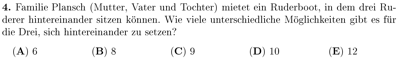

associated_images: <none>
============================== Option A ==============================
text: '6'
image: <none>
============================== Option B ==============================
text: '8'
image: <none>
============================== Option C ==============================
text: '9'
image: <none>
============================== Option D ==============================
text: '10'
image: <none>
============================== Option E ==============================
text: '12'
image: <none>
============================== End ==============================


In [4]:
# --- Display selected rows ---
rows_to_show = []
if row_indices:
    for idx in row_indices:
        if idx < 0 or idx >= len(df):
            print(f'Index {idx} out of range (dataset has {len(df)} rows)')
            continue
        rows_to_show.append((f'index {idx}', df.iloc[idx]))

if row_ids:
    id_matches = df[df['id'].isin(row_ids)]
    if id_matches.empty:
        missing = sorted(set(row_ids) - set(df['id'].tolist()))
        if missing:
            print(f'IDs not found: {missing}')
    for _, row in id_matches.iterrows():
        rows_to_show.append((f"id {row['id']}", row))

if not rows_to_show:
    print('No rows selected yet. Populate `row_indices` or `row_ids` above and rerun.')
else:
    for label, row in rows_to_show:
        show_question(row, row_label=label)


=== Prompt for id 01_34_p1_efb9c554-56b1-4719-ac26-d6c0dcf11e68 ===
[
  {
    "role": "system",
    "content": "Du bist ein hilfreicher Assistent für Multiple-Choice-Aufgaben.\nBewertung: Eine korrekte Antwort erhält die vollen Punkte der Aufgabe; eine falsche oder nicht eindeutig auswertbare Endantwort zieht ein Viertel der Aufgabenpunkte ab; 'Ich entscheide mich, nicht zu antworten.' ergibt 0 Punkte ohne Abzug.\nWähle die beste Option (A–E). Wenn die richtige Option nicht mit ausreichender Sicherheit bestimmbar ist oder die Aufgabe mehrdeutig ist, kannst du ausdrücklich mit 'Ich entscheide mich, nicht zu antworten.' antworten. Begründungen sind optional.\nFüge am Ende eine einzelne Zeile an: Final answer: A|B|C|D|E|Declined."
  },
  {
    "role": "user",
    "content": [
      {
        "type": "text",
        "text": "Frage: 4. Familie Plansch (Mutter, Vater und Tochter) mietet ein Ruderboot, in dem drei Ruderer hintereinander sitzen können. Wie viele unterschiedliche Möglichkeiten 
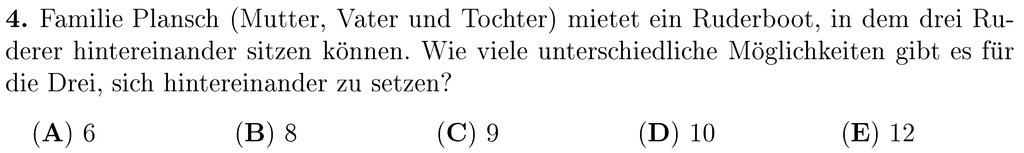

In [5]:
# --- Print LLM Prompts (using eval_run.py exact functions) ---
import json
from typing import Any, Dict, List

# Import the exact implementations used during evaluation
from eval_run import (
    build_messages,
    coerce_bytes,
    coerce_list_of_bytes,
    pil_from_bytes,
    image_to_data_url,
)

# Now build and print the prompts exactly as evaluation would
if not rows_to_show:
    print('No rows selected yet. Populate `row_indices` or `row_ids` above and rerun.')
else:
    for label, row in rows_to_show:
        print(f"=== Prompt for {label} ===")

        # Assemble encoded_images exactly like in evaluation
        encoded_images: Dict[str, Any] = {"assoc_list": []}

        # Question image
        q_bytes = coerce_bytes(row.get("question_image"))
        if q_bytes:
            q_img = pil_from_bytes(q_bytes)
            if q_img:
                data_url, _mime = image_to_data_url(q_img)
                encoded_images["question"] = data_url

        # Associated images
        assoc_list = coerce_list_of_bytes(row.get("associated_images_bin")) or []
        for blob in assoc_list:
            a_img = pil_from_bytes(blob)
            if a_img:
                data_url, _mime = image_to_data_url(a_img)
                encoded_images["assoc_list"].append(data_url)

        # Option images A..E
        opt_map: Dict[str, str] = {}
        for letter in ["A", "B", "C", "D", "E"]:
            b = coerce_bytes(row.get(f"sol_{letter}_image_bin"))
            if b:
                o_img = pil_from_bytes(b)
                if o_img:
                    data_url, _mime = image_to_data_url(o_img)
                    opt_map[letter] = data_url
        encoded_images["options"] = opt_map

        # Build messages exactly like evaluation
        messages = build_messages(row, encoded_images=encoded_images, image_detail="auto")

        # Print the exact JSON payload that becomes the "messages" field
        print(json.dumps(messages, indent=2, ensure_ascii=False))
        print()